# Debugging:
## This script imports C and Python HDF output for comparison

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import subprocess

Convert all hdf4 output of RKLM C-code to hdf5.

In [2]:
base_folder_name = "output"
# base_suffix = '_acoustic_wave_high/'
# base_suffix = '_internal_long_wave/'
base_suffix = '_travelling_vortex_3d_48_no_initial_projection/'
base_path = base_folder_name + base_suffix
folder_comp = "low_Mach_gravity_comp/"
folder_psinc = "low_Mach_gravity_psinc/"

directories = ['S', 'T', 'Y', 'buoy', 'dT', 'dY', 'dp2_c', 'dp2_nodes', 'dpdim', 'drhoY', 'p', 'p2_c', 'p2_nodes', 'rho', 'rhoY', 'rhoe', 'u', 'v', 'vortz', 'w']
directories += ['rhou', 'rhov', 'rhow']
filenames = ['S', 'T', 'Y', 'buoy', 'dT', 'dY', 'dp2_c', 'dp2_n', 'dpdim', 'drhoY', 'p', 'p2_c', 'p2_n', 'rho', 'rhoY', 'rhoe', 'u', 'v', 'vortz', 'w']
filenames += ['rhou', 'rhov', 'rhow']
hdf_format = '.'+ 'hdf'
h5_format = '.' + 'h5'
time = '000'
string_hdf = '_' + time + hdf_format
string_h5 = '_' + time + h5_format

full_path = base_path + folder_comp

lst_hdf = []
lst_h5 = []

i = 0
for directory in directories:
    lst_hdf.append(full_path + directory + '/' + filenames[i] + string_hdf)
    lst_h5.append(full_path + directory + '/' + filenames[i] + string_h5)
    i += 1 

print(lst_hdf)
for item in lst_hdf:
    p = subprocess.call(["./h4toh5convert", item])


# hf = h5py.File(lst_h5[2], 'r')
# print(list(hf.keys()))
# dd = hf['Data-Set-2']
# print(dd)

['output_travelling_vortex_3d_48_no_initial_projection/low_Mach_gravity_comp/S/S_000.hdf', 'output_travelling_vortex_3d_48_no_initial_projection/low_Mach_gravity_comp/T/T_000.hdf', 'output_travelling_vortex_3d_48_no_initial_projection/low_Mach_gravity_comp/Y/Y_000.hdf', 'output_travelling_vortex_3d_48_no_initial_projection/low_Mach_gravity_comp/buoy/buoy_000.hdf', 'output_travelling_vortex_3d_48_no_initial_projection/low_Mach_gravity_comp/dT/dT_000.hdf', 'output_travelling_vortex_3d_48_no_initial_projection/low_Mach_gravity_comp/dY/dY_000.hdf', 'output_travelling_vortex_3d_48_no_initial_projection/low_Mach_gravity_comp/dp2_c/dp2_c_000.hdf', 'output_travelling_vortex_3d_48_no_initial_projection/low_Mach_gravity_comp/dp2_nodes/dp2_n_000.hdf', 'output_travelling_vortex_3d_48_no_initial_projection/low_Mach_gravity_comp/dpdim/dpdim_000.hdf', 'output_travelling_vortex_3d_48_no_initial_projection/low_Mach_gravity_comp/drhoY/drhoY_000.hdf', 'output_travelling_vortex_3d_48_no_initial_projection

Import the test case arrays from the c-output.

In [3]:
test_cases_folders = ['p2_c', 'dp2_nodes', 'p', 'p2_nodes', 'rho', 'rhoY', 'rhoe', 'rhou', 'rhov', 'rhow', 'u', 'vortz', 'dpdim', 'T', 'dT', 'Y', 'dY', 'dp2_c']
test_cases_folders = np.char.array(test_cases_folders)

test_cases_names = ['p2_c', 'dp2_n', 'p', 'p2_n', 'rho', 'rhoY', 'rhoe', 'rhou', 'rhov', 'rhow', 'u', 'vortz', 'dpdim', 'T', 'dT', 'Y', 'dY', 'dp2_c']
test_cases_names = np.char.array(test_cases_names)

test_cases_paths = full_path + test_cases_folders + '/' + test_cases_names + string_h5

class c_output(object):
    def __init__(self):
        None

Import the python output.

In [4]:
py_directory = "../RKLM_Python/"
# py_filename = "output_acoustic_wave_high_low_mach_gravity_comp.h5"
# py_filename = "output_internal_long_wave_low_mach_gravity_comp.h5"
py_filename = "output_travelling_vortex_3d_48_low_mach_gravity_comp.h5"
py_path = py_directory + py_filename

def py_out(py_dataset):
    return pyfile[str(py_dataset)][str(py_dataset)+'_000'][:]

In [5]:
def p(obj):
    print(obj['Data-Set-2'][:])
    
def v(obj):
    plt.imshow(obj['Data-Set-2'][:])
    plt.colorbar()
    plt.show()
    
def s(obj):
    plt.plot(obj['Data-Set-2'][:,0])
    plt.show()
    
def diff(obj_c,obj_py, title):
    obj_c = obj_c['Data-Set-2']
    obj_py = obj_py
    
    c_range = np.max(obj_c) - np.min(obj_c)
    py_range = np.max(obj_py) - np.min(obj_py)
    max_norm = np.abs(obj_c - obj_py)
    
#     if np.max(max_norm) > 0.0:
    fig, ax = plt.subplots(ncols=3)
    im_c = ax[0].imshow(obj_c, label="c")
    fig.colorbar(im_c,ax=ax[0])
    ax[0].set_title("c")
    ax[0].set_aspect('auto')

    im_py = ax[1].imshow(obj_py, label="py")
    fig.colorbar(im_py,ax=ax[1])
    ax[1].set_title("py")
    ax[1].set_aspect('auto')

    im_diff = ax[2].imshow(max_norm, label="diff")
    fig.colorbar(im_diff,ax=ax[2])
    ax[2].set_title("diff")
    ax[2].set_aspect('auto')
#     plt.colorbar()

    max_diff = np.max(max_norm)
    if c_range == 0.0:
        rel_diff = 0.0
    else:
        rel_diff = max_diff/c_range
    print("comparison = %s,\nc_range = %e, py_range = %e, \nmax diff = %e, rel. diff = %e," %(title, c_range, py_range, max_diff, rel_diff))
    plt.tight_layout(h_pad=1)
    plt.show()
    print("################################################## \n")

comparison = rho,
c_range = 4.959447e-01, py_range = 4.959448e-01, 
max diff = 2.946066e-08, rel. diff = 5.940311e-08,


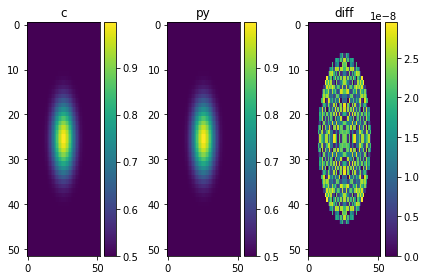

################################################## 

comparison = rhoe,
c_range = 4.768372e-07, py_range = 5.789779e-07, 
max diff = 1.172759e-07, rel. diff = 2.459455e-01,


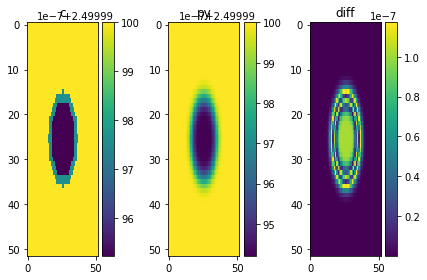

################################################## 

comparison = rhoY,
c_range = 1.788139e-07, py_range = 1.654223e-07, 
max diff = 2.952291e-08, rel. diff = 1.651041e-01,


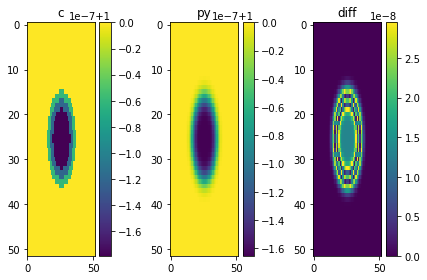

################################################## 



In [6]:
c = c_output()

i = 0
for path in test_cases_paths:
    setattr(c,test_cases_folders[i],h5py.File(path, 'r'))
    i += 1

pyfile = h5py.File(py_path, 'r')

# diff(c.dp2_nodes,py_out('dp2_nodes'),'dp2_nodes')
# diff(c.p2_nodes,py_out('p2_nodes'),'p2_nodes')
# diff(c.dp2_c,py_out('dp2_cells'),'dp2_cells')
# diff(c.p2_c,py_out('p2_cells'),'p2_cells')

diff(c.rho,py_out('rho'),'rho')
diff(c.rhoe,py_out('rhoe'),'rhoe')
diff(c.rhoY,py_out('rhoY'),'rhoY')

# diff(c.rhou,py_out('rhou'),'rhou')
# diff(c.rhov,py_out('rhov'),'rhov')
# diff(c.rhow,py_out('rhow'),'rhow')

# diff(c.u, py_out('u'), 'u')
# diff(c.p, py_out('p'), 'p')
# diff(c.dpdim, py_out('dpdim'), 'dpdim')
# diff(c.vortz, py_out('vortz'), 'vortz')

# diff(c.T, py_out('T'), 'T')
# diff(c.dT, py_out('dT'), 'dT')

# diff(c.Y, py_out('Y'), 'Y')
# diff(c.dY, py_out('dY'), 'dY')

# c_rhoe = c.rhoe['Data-Set-2'][:]
# py_rhoe = py_out('rhoe')
# print(c_rhoe[15:25,15:25])
# print(py_rhoe[15:25,15:25])
pyfile.close()



In [184]:
pyfile.close()